# Cluster genes along pseudotime 

Summary of time series clustering in R  
https://journal.r-project.org/archive/2016/RJ-2016-058/index.html  
https://cran.r-project.org/web/packages/dtwclust/vignettes/dtwclust.pdf  

### Distance meassures 

Shape meassures: Lock-step (n=m) and elastic (n!=m)  
Feature based: Fourier or wavelet coefficients, autocorrelation values, etc.  
Structure-based: (i) model-based approaches, where a model is fit to each series and the comparison is made between models, and (ii) complexity-based models, where the similarity between two series is measured based on the quantity of shared information.  
Prediction-based distances analyze the similarity of the forecasts obtained for different time series.  

In [1]:
options(warn=-1)
options(dplyr.summarise.inform=FALSE)

In [2]:
library_load <- suppressMessages(
    
    list(
        
        # parallelDist
        library(parallelDist), 
        
        # TradeSeq
        library(tradeSeq), 
        
        # Seurat 
        library(Seurat), 
        
        # GSEA
        library(fgsea), 
        library(msigdbr), 
        
        # Data 
        library(tidyverse), 
        
        # Plotting 
        library(ggplot2), 
        library(patchwork), 
        library(ggplotify),
        library(ComplexHeatmap),
        library(circlize)
        
    )
)

In [3]:
random_seed <- 42
set.seed(random_seed)

In [4]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [5]:
# Source files
source("plotting_global.R")
source("bin/tradeseq_pp.R")
source("bin/tradeseq_pl.R")

In [6]:
# Plotting Theme
ggplot2::theme_set(theme_global_set(size_select=1)) # From project global source()

# Parameter settings 

In [7]:
tradeseq_res_file <- "result/lineage/tradeseq_res_2.rds"

In [8]:
dist_method <- "euclidean"
hclust_method <- "ward.D2"

In [9]:
n_points <- 5
n_points_plot <- 50

In [10]:
k_ptag <- 10 
k_ptcg <- 10
k_ptpg <- 10

In [11]:
ptpg_padj_pvalue_thr <- 0.05

In [12]:
contrast_vec <- list(

    c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1"), 
    c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D3"), 
    c("IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3"), 
    c("IFNAR_fl_LysM_cre_Baseline_D0", "IFNAR_fl_LysM_cre_CpG_D1"), 
    c("IFNAR_fl_LysM_cre_Baseline_D0", "IFNAR_fl_LysM_cre_CpG_D3"), 
    c("IFNAR_fl_LysM_cre_CpG_D1", "IFNAR_fl_LysM_cre_CpG_D3"), 
    c("IFNAR_fl_Baseline_D0", "IFNAR_fl_LysM_cre_Baseline_D0"), 
    c("IFNAR_fl_CpG_D1", "IFNAR_fl_LysM_cre_CpG_D1"), 
    c("IFNAR_fl_CpG_D3", "IFNAR_fl_LysM_cre_CpG_D3")
    
)

In [32]:
df <- conditionTest(fitgam, l2fc=0.25, pairwise=TRUE)

# Import data 

In [13]:
tradeseq_res <- readRDS(tradeseq_res_file)

In [14]:
fitgam <- tradeseq_res[[1]]
ptag <- tradeseq_res[[2]]
condition_color <- color$sample_group[colnames(ptag)]

# Get log smoothed data for all PTAG

In [15]:
# Subset for PTAG genes
genes_ptag <- ptag[rowSums(ptag)>0, ] %>% rownames()

In [16]:
# Set PTAG for all samples
ptag[rownames(ptag) %in% genes_ptag, ] <- TRUE

In [17]:
# Remove genes without pseudotime association 
ptag <- ptag[rowSums(ptag) > 0, ]

In [18]:
# Get counts
counts <- assay(fitgam)[rownames(ptag), ]
    
# Get meta data
meta <- data.frame(condition=fitgam$tradeSeq$conditions, dpt=fitgam$crv$pseudotime)
rownames(meta) <- colnames(fitgam)
    
# Create Seurat object
so <- CreateSeuratObject(counts=counts, meta.data=meta, assay="RNA")

In [19]:
message(paste0("PTAG genes: ", nrow(ptag)))

PTAG genes: 8407



In [20]:
# Smooth log expression 
mat <- predictSmooth(fitgam, genes_ptag, nPoints=n_points, tidy=TRUE) %>% dplyr::select(-lineage)

# Pseudotime perturbed genes (PTPG) 

## Generate background distribution per condition to estimate mean and sd of the Euclidean distance from similar behaving genes in cluster

In [21]:
hclust_ptag_res <- lapply(colnames(ptag), function(i) {
    
    ptag_genes_i <- setNames(ptag[, i], rownames(ptag))
    
    mat_i <- mat %>% dplyr::filter(condition==i, gene %in% names(ptag_genes_i[ptag_genes_i])) %>% dplyr::select(-condition) %>% 
        # dplyr::mutate(time_bin=cut(x=time, breaks=seq(0, 1, length.out=11), labels=seq(0.05, 0.95, 0.1), include.lowest=TRUE, right=FALSE)) %>% 
        # dplyr::group_by(gene, time_bin) %>% dplyr::summarise(yhat=mean(yhat)) %>% 
        # dplyr::rename(time=time_bin) %>% 
        pivot_wider(., names_from=time, values_from=yhat) %>% tibble::column_to_rownames("gene")
    
    mat_i <-  t(apply(mat_i, 1, scales::rescale))
    dist_i <- parallelDist::parDist(mat_i, method=dist_method)
    hclust_i <- hclust(dist_i, hclust_method)

    return(list(mat_i, hclust_i))
    
}
                    )

In [22]:
names(hclust_ptag_res) <- colnames(ptag)

In [23]:
elbow_wcss_plot <- function(scale_data, hclust_result, cluster_k=100, cluster_k_thr=10, title="Elbow plot") {

    cluster_k <- 1:cluster_k
    wcss_k <- c()

    for(k in cluster_k) {
        
        cluster_i <- cutree(hclust_result, k)
        wcss_i <- c()
            
        for(i in unique(cluster_i)) {
            
                x <- scale_data[which(cluster_i==i), , drop=FALSE]
                wcss <- (nrow(x)-1)*sum(apply(x, 2, var))
                if(is.na(wcss)) {wcss=0}
                wcss_i[i] <- wcss

        }

        wcss_k[k] <- sum(wcss_i)

    }
    
    elbow_wcss_plot <- ggplot(data.frame(wcss=wcss_k, cluster_k=cluster_k), aes(x=cluster_k, y=wcss)) + 
        geom_line(size=1) + 
        geom_point(size=3, shape=21, fill="black", color="white") + 
        geom_vline(xintercept=cluster_k_thr, color="red", linetype="longdash") + 
        xlab("Number of Clusters") + ylab("Within groups sum of squares") + ggtitle(title)

    return(elbow_wcss_plot)


}

In [24]:
elbow_wcss_plot_ptag <- lapply(names(hclust_ptag_res), function(i) {
    
    elbow_wcss_plot(hclust_ptag_res[[i]][[1]], hclust_ptag_res[[i]][[2]], 100, k_ptag, title=paste0("PTAG (", i, ")"))
    
}
                   )

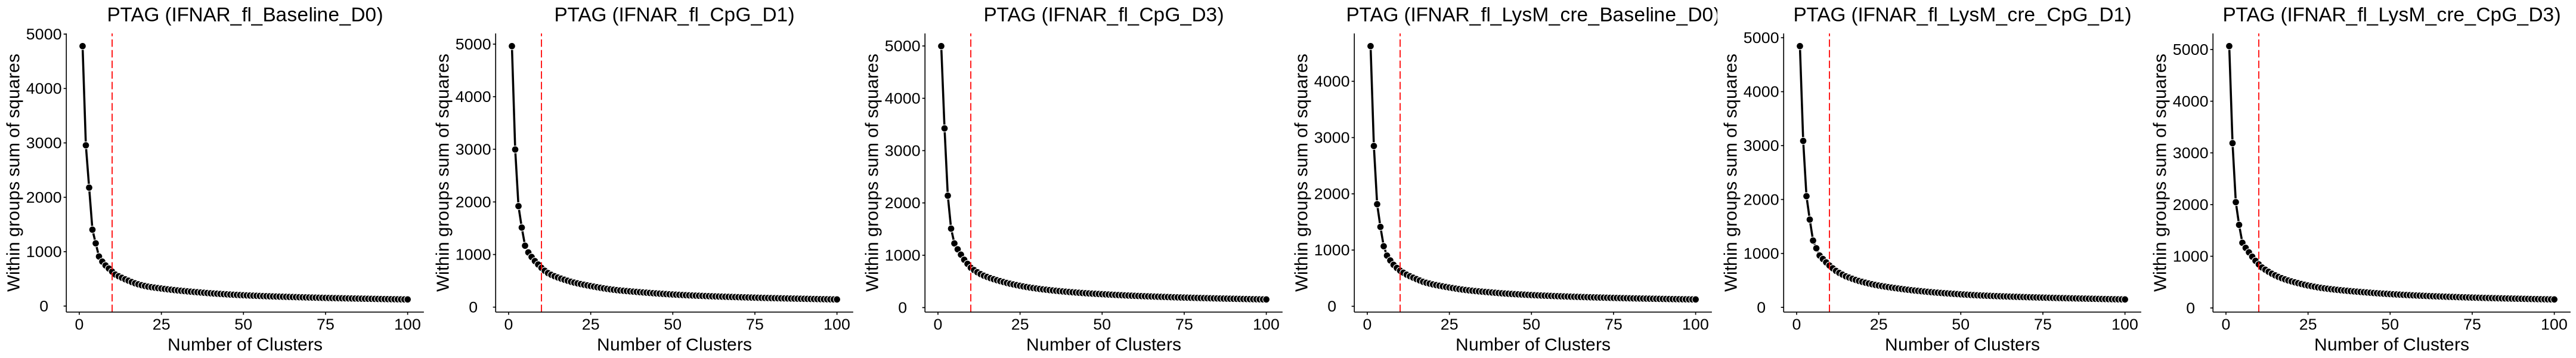

In [25]:
options(repr.plot.width=length(elbow_wcss_plot_ptag)*6, repr.plot.height=5)

ggpubr::ggarrange(plotlist=elbow_wcss_plot_ptag, ncol=length(elbow_wcss_plot_ptag), nrow=1, common.legend=FALSE, legend="bottom")

In [26]:
cluster_dist <- function(cnt_scale, hclust, condition, k=10) {
    
    cluster_label <- cutree(hclust, k)
    cluster_label_unique <- unique(cluster_label)[order(unique(cluster_label))]

    cluster_dist <- list()
    for(cluster_label_i in cluster_label_unique) {

        cnt_scale_i <- cnt_scale[which(cluster_label==cluster_label_i), , drop=FALSE] # Can output single row matrix which produces NaN in parDist
        dist_i <- parallelDist::parDist(cnt_scale_i, method=dist_method)

        cluster_dist[[cluster_label_i]] <- data.frame(

            cluster=cluster_label_i, 
            dist=mean(dist_i), 
            dist_norm=mean(dist_i^(1/3))

        )

    }
    
    cluster_dist <- do.call("rbind", cluster_dist)

    cluster_dist$condition <- condition
    
    return(cluster_dist)
   
}

In [27]:
cluster_dist_condition <- lapply(names(hclust_ptag_res), function(i) {

    cluster_dist(hclust_ptag_res[[i]][[1]], hclust_ptag_res[[i]][[2]], condition=i, k=k_ptag)
    
}
                   )

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



In [28]:
cluster_dist_condition <- do.call(rbind, cluster_dist_condition)
cluster_dist_condition <- na.omit(cluster_dist_condition)

## PTPG scoring for each gene between conditions 

In [29]:
ptpg <- lapply(contrast_vec, function(i) {

    ptag_genes_i <- ptag %>% dplyr::filter(rowSums(.)>0) %>% rownames()
    
    mat_i <- mat %>% dplyr::filter(condition %in% i, gene %in% ptag_genes_i) 
    breaks_cut_i <- mat_i$time[1:n_points]

    mat_i <- mat_i %>% 
        dplyr::mutate(time=paste0(time, ":", condition)) %>% dplyr::select(-condition) %>% 
        pivot_wider(., names_from=time, values_from=yhat) %>% tibble::column_to_rownames("gene")

    mat_i <-  t(apply(mat_i, 1, scales::rescale))
    
    dist_i <- lapply(1:nrow(mat_i), function(j) {parallelDist::parDist(list(mat_i[j, 1:n_points, drop=FALSE], mat_i[j, (n_points+1):(2*n_points), drop=FALSE]), method=dist_method)})

    ptpg_i <- data.frame(gene=rownames(mat_i), dist=do.call("c", dist_i)) %>% na.omit()
    ptpg_i$dist_norm <- ptpg_i$dist^(1/3)

    ptpg_i$pval <- pnorm(ptpg_i$dist_norm, mean=mean(cluster_dist_condition$dist_norm), sd=sd(cluster_dist_condition$dist_norm), lower.tail=FALSE)
    ptpg_i$padj <- p.adjust(ptpg_i$pval, method="BH")

    ptpg_i$ptpg <- ifelse(ptpg_i$padj<=ptpg_padj_pvalue_thr, TRUE, FALSE)

    message(paste(i[[1]], "vs", i[[2]]))
    message(paste0("PTCG: ", sum(ptpg_i$ptpg==FALSE)))
    message(paste0("PTPG: ", sum(ptpg_i$ptpg==TRUE)))

    return(ptpg_i)
    
}
      ) 

IFNAR_fl_Baseline_D0 vs IFNAR_fl_CpG_D1

PTCG: 2874

PTPG: 5533

IFNAR_fl_Baseline_D0 vs IFNAR_fl_CpG_D3

PTCG: 4618

PTPG: 3789

IFNAR_fl_CpG_D1 vs IFNAR_fl_CpG_D3

PTCG: 4770

PTPG: 3637

IFNAR_fl_LysM_cre_Baseline_D0 vs IFNAR_fl_LysM_cre_CpG_D1

PTCG: 4501

PTPG: 3906

IFNAR_fl_LysM_cre_Baseline_D0 vs IFNAR_fl_LysM_cre_CpG_D3

PTCG: 5443

PTPG: 2964

IFNAR_fl_LysM_cre_CpG_D1 vs IFNAR_fl_LysM_cre_CpG_D3

PTCG: 5560

PTPG: 2847

IFNAR_fl_Baseline_D0 vs IFNAR_fl_LysM_cre_Baseline_D0

PTCG: 6898

PTPG: 1509

IFNAR_fl_CpG_D1 vs IFNAR_fl_LysM_cre_CpG_D1

PTCG: 5273

PTPG: 3134

IFNAR_fl_CpG_D3 vs IFNAR_fl_LysM_cre_CpG_D3

PTCG: 6333

PTPG: 2074



In [ ]:
options(repr.plot.width=15, repr.plot.height=5)

histo_plot <- function(ptpg) {

    histo_plot_1 <- ggplot(ptpg, aes(x=dist)) + 
        geom_histogram(aes(y=..density..), bins=25, fill="lightblue") + 
        stat_function(fun=dnorm, args=list(mean=mean(ptpg$dist), sd=sd(ptpg$dist))) + 
        geom_vline(xintercept=mean(ptpg$dist), color="red") + 
        geom_vline(xintercept=c(mean(ptpg$dist)-sd(ptpg$dist), mean(ptpg$dist)+sd(ptpg$dist)), color="red", linetype="longdash") + 
        xlab("Euclidean distance") + ylab("Density") + ggtitle("Density gene-wise distance") 
    
    histo_plot_2 <- ggplot(ptpg, aes(x=dist_norm)) + 
        geom_histogram(aes(y=..density..), bins=25, fill="lightblue") + 
        ylim(c(0, 4)) + 
        stat_function(fun=dnorm, args=list(mean=mean(ptpg$dist_norm), sd=sd(ptpg$dist_norm))) + 
        geom_vline(xintercept=mean(ptpg$dist_norm), color="red") + 
        geom_vline(xintercept=c(mean(ptpg$dist_norm)-sd(ptpg$dist_norm), mean(ptpg$dist_norm)+sd(ptpg$dist_norm)), color="red", linetype="longdash") + 
        xlab("Cube root (Euclidean distance)") + ylab("Density") + ggtitle("Density gene-wise distance")
    
    histo_plot_3 <- ggplot(ptpg, aes(x=dist_norm)) + 
        geom_histogram(aes(y=..density..), bins=25, fill="lightblue") + 
        ylim(c(0, 4)) + 
        stat_function(fun=dnorm, args=list(mean=mean(cluster_dist_condition$dist_norm), sd=sd(cluster_dist_condition$dist_norm))) + 
        geom_vline(xintercept=mean(cluster_dist_condition$dist_norm), color="red") + 
        geom_vline(xintercept=c(mean(cluster_dist_condition$dist_norm)-sd(cluster_dist_condition$dist_norm), mean(cluster_dist_condition$dist_norm)+sd(cluster_dist_condition$dist_norm)), color="red", linetype="longdash") + 
        xlab("Cube root (Euclidean distance)") + ylab("Density") + ggtitle("Density gene-wise distance")
    
    histo_plot_1 + histo_plot_2 + histo_plot_3 + plot_layout(ncol=3)
    
}


In [ ]:
options(repr.plot.width=30, repr.plot.height=5)

ggpubr::ggarrange(plotlist=lapply(ptpg, histo_plot), ncol=2, nrow=1, common.legend=FALSE, legend="bottom")

## PCA of per-gene Euclidean distance 

In [ ]:
pca_ptag <- lapply(contrast_vec, function(i) {

    ptag_genes_i <- ptag[, i] %>% dplyr::filter(rowSums(.)>0) %>% rownames()
    
    mat_i <- mat %>% dplyr::filter(condition %in% i, gene %in% ptag_genes_i) %>% 
        dplyr::mutate(time=paste0(time, ":", condition)) %>% dplyr::select(-condition) %>% 
        pivot_wider(., names_from=time, values_from=yhat) %>% tibble::column_to_rownames("gene")

    mat_i <-  t(apply(mat_i, 1, scales::rescale))
    mat_i <- mat_i[apply(mat_i, 1, function(x) all(is.finite(x))), ]
    
    pca_ptag <- stats::prcomp(mat_i[, 1:n_points]-mat_i[, (n_points+1):(2*n_points)], center=FALSE, scale=FALSE)

    return(pca_ptag)
    
}
      ) 

In [ ]:
screen_plot <- function(pca_result) {
    
    screen_data=data.frame(pc=1:length(pca_result$sdev), var_explained=pca_result$sdev^2 / sum(pca_result$sdev^2))
    screen_plot <- ggplot(screen_data, aes(x=pc, y=var_explained)) + 
        geom_line(size=1) + 
        geom_point(size=3, shape=21, fill="black", color="white") + 
        xlim(1, 10) + 
        xlab("Principal Component") + ylab("Variance Explained") + ggtitle("Scree Plot") + 
        theme(
            aspect.ratio=1, 
            legend.position="none"
        )
    
    return(screen_plot)
    
}

In [ ]:
options(repr.plot.width=25, repr.plot.height=5)

ggpubr::ggarrange(plotlist=lapply(pca_ptag, screen_plot), ncol=9, nrow=1, common.legend=FALSE, legend="bottom")

In [ ]:
pca_plot <- function(pca_result, ptpg, pc_1=1, pc_2=pc_1+1) {

    pca_data <- cbind(as.data.frame(pca_result$x), ptpg)
    
    pca_plot <- ggplot(pca_data, aes_string(x=paste0("PC", pc_1), y=paste0("PC", pc_2), fill="ptpg")) + 
        geom_point(size=3, shape=21, alpha=0.3, color="white") + 
        scale_fill_manual(values=c("TRUE"="gray", "FALSE"="darkblue")) + 
        theme(
            aspect.ratio=1, 
            legend.position="bottom"
        ) + 
        
        guides(fill=guide_legend(override.aes=list(alpha=1)))
    
    return(pca_plot)
    
}

In [ ]:
options(repr.plot.width=40, repr.plot.height=7.5)

lapply(1:length(pca_ptag), function(i) {
    
    p_list <- lapply(1:4, function(j) {pca_plot(pca_ptag[[i]], ptpg[[i]], pc_1=j)})
    ggpubr::ggarrange(plotlist=p_list, ncol=10, nrow=1, common.legend=FALSE, legend="bottom")
    
}
      )

# Cluster PTCG and PTPG per contrast

In [ ]:
hclust_ptcg_res <- lapply(seq_along(contrast_vec), function(i) {

    ptcg_genes_i <- ptpg[[i]] %>% dplyr::filter(!ptpg) %>% dplyr::pull(gene)
    
    mat_i <- mat %>% dplyr::filter(condition %in% contrast_vec[[i]], gene %in% ptcg_genes_i) %>% dplyr::mutate(time=paste0(time, ":", condition)) %>% dplyr::select(-condition) %>% 
        pivot_wider(., names_from=time, values_from=yhat) %>% tibble::column_to_rownames("gene")

    mat_i <- t(apply(mat_i, 1, scales::rescale))
    
    dist_i <- parallelDist::parDist(mat_i, method=dist_method)
    hclust_i <- hclust(dist_i, hclust_method)

    return(list(mat_i, hclust_i))
    
}
                    )

In [ ]:
hclust_ptpg_res <- lapply(seq_along(contrast_vec), function(i) {

    ptcg_genes_i <- ptpg[[i]] %>% dplyr::filter(ptpg) %>% dplyr::pull(gene)
    
    mat_i <- mat %>% dplyr::filter(condition %in% contrast_vec[[i]], gene %in% ptcg_genes_i) %>% dplyr::mutate(time=paste0(time, ":", condition)) %>% dplyr::select(-condition) %>% 
        pivot_wider(., names_from=time, values_from=yhat) %>% tibble::column_to_rownames("gene")

    mat_i <-  t(apply(mat_i, 1, scales::rescale))
    
    dist_i <- parallelDist::parDist(mat_i, method=dist_method)
    hclust_i <- hclust(dist_i, hclust_method)

    return(list(mat_i, hclust_i))
    
}
                    )

In [ ]:
elbow_wcss_plot_ptcg <- lapply(seq_along(hclust_ptcg_res), function(i) {
    
    elbow_wcss_plot(hclust_ptcg_res[[i]][[1]], hclust_ptcg_res[[i]][[2]], 50, k_ptcg, title=paste0("PTCG (", i, ")"))
    
}
                   )

In [ ]:
options(repr.plot.width=length(elbow_wcss_plot_ptcg)*6, repr.plot.height=5)

ggpubr::ggarrange(plotlist=elbow_wcss_plot_ptcg, ncol=length(elbow_wcss_plot_ptcg), nrow=1, common.legend=FALSE, legend="bottom")

In [ ]:
elbow_wcss_plot_ptpg <- lapply(seq_along(hclust_ptpg_res), function(i) {
    
    elbow_wcss_plot(hclust_ptpg_res[[i]][[1]], hclust_ptpg_res[[i]][[2]], 50, k_ptpg, title=paste0("PTPG (", i, ")"))
    
}
                   )

In [ ]:
options(repr.plot.width=length(elbow_wcss_plot_ptpg)*6, repr.plot.height=5)

ggpubr::ggarrange(plotlist=elbow_wcss_plot_ptpg, ncol=length(elbow_wcss_plot_ptpg), nrow=1, common.legend=FALSE, legend="bottom")

# Plot results

## Plot cluster genes 

In [ ]:
cluster_plot <- function(i, cluster, n_points, condition_color=NULL, prototype=FALSE) {
    
    cluster_label <- cluster
    cluster_label_unique <- unique(cluster_label)[order(unique(cluster_label))]

    mat_i <- predictSmooth(fitgam, gene=names(cluster_label), nPoints=n_points, tidy=TRUE)
    mat_i <- mat_i %>% dplyr::filter(condition %in% contrast_vec[[i]]) 

    mat_i <- mat_i %>% dplyr::group_by(gene) %>% dplyr::mutate(yhat=scales::rescale(yhat))

    p_list <- list()
    
    for(cluster_label_i in cluster_label_unique) {
        
        mat_i_j <- mat_i[mat_i$gene %in% names(cluster_label[cluster_label==cluster_label_i]), ]
        
        if(prototype) {
            
            suppressMessages(mat_i_j <- dplyr::group_by(mat_i_j, time, condition) %>% dplyr::summarise(yhat=mean(yhat)))
            p <- ggplot(mat_i_j, aes(x=time, y=yhat, color=condition, group=paste(condition))) + geom_line(size=3, alpha=1)
            
        } else {
            
            p <- ggplot(mat_i_j, aes(x=time, y=yhat, color=condition, group=paste(condition, gene))) + geom_line(size=1, alpha=1)
            
        }
        
        p_list[[paste("Cluster", cluster_label_i)]] <- p +  
            geom_hline(yintercept=0, linetype="dashed") + 
            ggtitle(paste("Cluster", cluster_label_i)) + 
            scale_color_manual(values=condition_color) + 
            theme(legend.position="bottom")
        
    }
    
    return(p_list)
    
}

In [ ]:
hm_pt_cluster_smooth <- function(fitgam, cluster, cluster_order=NULL, condition_test=NULL, n_points, width=1.0, height=0.005, user_raster=FALSE, column_title=NULL, use_raster=FALSE, condition_color=NULL) {

    # Set genes and cluster 
    genes <- names(cluster)
    cluster <- as.character(cluster)
    
    # Set cluster order 
    if(!is.null(cluster_order)) {cluster <- factor(cluster, levels=cluster_order)}
    
    # Get smoothed data
    mat <- predictSmooth(fitgam, gene=genes, nPoints=n_points, tidy=TRUE)
    mat <- mat %>% dplyr::filter(condition %in% names(condition_color))
    mat <- mat %>% dplyr::mutate(time=paste0(time, ":", condition)) %>% dplyr::select(-lineage, -condition) %>% pivot_wider(., names_from=time, values_from=yhat) %>% tibble::column_to_rownames("gene")
    mat <- t(apply(mat, 1, scales::rescale))
    
    # Color mat
    breaks_mat <- seq(0, 1, length.out=4)
    color_function_mat <- viridis::mako(length(breaks_mat))

    # Column annotation 
    top_annotation <- HeatmapAnnotation(

        df=data.frame(condition=factor(c(rep(names(condition_color)[1], n_points), rep(names(condition_color)[2], n_points)), levels=names(condition_color))), 
        col=list(condition=condition_color), 
        simple_anno_size=unit(6, "mm"), 
        show_annotation_name=FALSE, 
        show_legend=FALSE

    )
    
    
   
    hm_1 <- Heatmap(

        matrix=mat, 

        col=color_function_mat, 
        na_col="white", 

        width=n_points*unit(width, "mm"),
        height=unit(163, "mm"),

        # row_title=NULL, 
        row_title_gp=gpar(fontsize=18, fontface="bold"), 

        column_title=column_title, 
        column_title_gp=gpar(fontsize=18, fontface="bold"), 

        row_names_gp=gpar(fontsize=16, fontface="plain"), 
        column_names_gp=gpar(fontsize=18, fontface="plain"), 

        cluster_rows=TRUE, 
        cluster_row_slices=FALSE, 
        show_row_dend=FALSE,   
        row_split=cluster, 
        row_gap=unit(2, "mm"),
        show_row_names=FALSE,
        row_names_side="right",

        cluster_columns=FALSE,
        cluster_column_slices=FALSE, 
        show_column_dend=FALSE, 
        column_split=factor(c(rep(condition_color[1], n_points), rep(condition_color[2], n_points)), levels=condition_color), ,
        column_gap=unit(2, "mm"), 
        show_column_names=FALSE, 

        top_annotation=top_annotation, 
        right_annotation=NULL, 

        rect_gp=gpar(col=NA, lwd=0, alpha=1), 

        heatmap_legend_param=list(title="Expression", title_gp=gpar(fontsize=18, fontface="plain"), labels_gp=gpar(fontsize=16), legend_height=unit(5*6, "mm"), grid_width=unit(6, "mm")), 

        border=FALSE, 
        border_gp=gpar(col="black", lwd=unit(0.5, "mm")), 

        use_raster=use_raster, 
        
        raster_resize_mat=mean

    )
    
    return(hm_1)  
    
    
}

## Cluster genes PTCG 

In [ ]:
options(repr.plot.width=5*10, repr.plot.height=5)

lapply(seq_along(hclust_ptcg_res), function(i) {

    lp_ptcg <- cluster_plot(i, cutree(hclust_ptcg_res[[i]][[2]], k_ptcg), n_points=n_points_plot, condition_color=condition_color[contrast_vec[[i]]], prototype=TRUE)

    ggpubr::ggarrange(plotlist=lp_ptcg, ncol=10, nrow=1, common.legend=FALSE, legend="bottom")
    
}
      )

In [ ]:
hm_list <- lapply(seq_along(hclust_ptcg_res), function(i) {

    if(!i %in% c(3, 6)) {
        
        hm_list <- hm_pt_cluster_smooth(fitgam, cluster=cutree(hclust_ptcg_res[[i]][[2]], k_ptcg), cluster_order=as.character(1:k_ptcg), n_points=n_points_plot, width=2.5*(50/n_points_plot), height=0.075, condition_color=condition_color[contrast_vec[[i]]], column_title="Canonical genes") %>% as.ggplot()
        
    }
    
}
      )

In [ ]:
hm_list <- hm_list[!lapply(hm_list, is.null) %>% unlist()]

In [ ]:
options(repr.plot.width=30, repr.plot.height=10)

ggpubr::ggarrange(plotlist=hm_list, ncol=4, nrow=1, common.legend=FALSE, legend="bottom")

## Cluster genes PTPG

In [ ]:
options(repr.plot.width=5*10, repr.plot.height=5)

lapply(seq_along(hclust_ptpg_res), function(i) {

    lp_ptpg <- cluster_plot(i, cutree(hclust_ptpg_res[[i]][[2]], k_ptpg), n_points=n_points_plot, condition_color=condition_color[contrast_vec[[i]]], prototype=TRUE)

    ggpubr::ggarrange(plotlist=lp_ptpg, ncol=10, nrow=1, common.legend=FALSE, legend="bottom")
    
}
      )

In [ ]:
hm_list <- lapply(seq_along(hclust_ptpg_res), function(i) {

    if(!i %in% c(3, 6)) {
        
        hm_list <- hm_pt_cluster_smooth(fitgam, cluster=cutree(hclust_ptpg_res[[i]][[2]], k_ptpg), cluster_order=as.character(1:k_ptpg), n_points=n_points_plot, width=2.5*(50/n_points_plot), height=0.075, condition_color=condition_color[contrast_vec[[i]]], column_title="Canonical genes") %>% as.ggplot()
    
    }
    
}
      )

In [ ]:
hm_list <- hm_list[!lapply(hm_list, is.null) %>% unlist()]

In [ ]:
options(repr.plot.width=30, repr.plot.height=10)

ggpubr::ggarrange(plotlist=hm_list, ncol=4, nrow=1, common.legend=FALSE, legend="bottom")

# Save results 

In [ ]:
names(ptpg) <- lapply(contrast_vec, function(x) paste0(x, collapse=":"))
tradeseq_res[["ptpg"]] <- purrr::imap_dfr(ptpg, ~ mutate(.x, contrast=.y))

In [ ]:
saveRDS(tradeseq_res, tradeseq_res_file)

# SessionInfo 

In [ ]:
sessionInfo()